<a href="https://colab.research.google.com/github/hukim1112/MLDL/blob/master/object_detection/training_loop_for_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SSD 모델 학습

SSD는 사전 정의된 cost 함수 대신 복합적인 cost 함수를 사용한다.

따라서 학습을 커스터마이징하기 위한 방법인 Customized model.fit 또는 loop training 방법을 사용해 학습한다.

In [1]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
import tensorflow.keras.layers as layers
import tensorflow as tf
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt

## 데이터 로드

https://drive.google.com/drive/folders/1z-FSY3JN-FWBl87XAZyb4m2KcHqJEUTm?usp=sharing

Colab 사용 시 GDUT_HWD.json과 images.zip을 Colab repository에 업로드 할 것.

In [4]:
#데이터셋 업로드 후 압축 풀 것.
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/03212.jpg        
  inflating: images/02757.jpg        
  inflating: images/02538.jpg        
  inflating: images/01328.jpg        
  inflating: images/02124.jpg        
  inflating: images/03370.jpg        
  inflating: images/01255.jpg        
  inflating: images/01790.jpg        
  inflating: images/00466.jpg        
  inflating: images/02077.jpg        
  inflating: images/00275.jpg        
  inflating: images/02005.jpg        
  inflating: images/00290.jpg        
  inflating: images/01447.jpg        
  inflating: images/02784.jpg        
  inflating: images/01381.jpg        
  inflating: images/01231.jpg        
  inflating: images/02151.jpg        
  inflating: images/01010.jpg        
  inflating: images/01864.jpg        
  inflating: images/02457.jpg        
  inflating: images/00836.jpg        
  inflating: images/00699.jpg        
  inflating: images/00462.jpg        
  inflating: images/02007.jpg        
  inflat

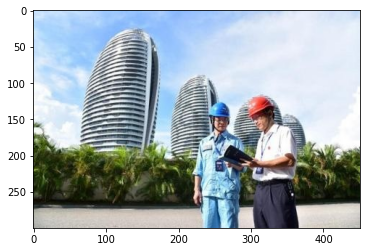

In [5]:
image_dir = '/content/images'
annotation = '/content/GDUT_HWD.json'

#압축
img_list = os.listdir(image_dir)
img_path = os.path.join(image_dir, img_list[0])
img = cv2.imread(img_path)[:,:,::-1]
plt.imshow(img)

In [6]:
import coco
from anchor import generate_default_boxes
from pycocotools.coco import COCO

# anchor box 생성
anchor_param = {"ratios": [[2], [2, 3], [2, 3], [2, 3], [2]],
                           "scales": [0.1, 0.3, 0.5, 0.7, 0.9, 1.075],
                           "fm_sizes": [28, 14, 7, 3, 1],
                           "image_size": 224} #anchor parameters
anchors = generate_default_boxes(anchor_param)

label_set = ["head","helmet"]
input_shape = (224,224,3)
batch_size = 16
shuffle_buffer = 159

ds_obj = coco.Dataset(COCO, anchors, image_dir, annotation, label_set, input_shape)
train_ds, train_length = ds_obj.load_data_generator('train')
train_ds = train_ds.shuffle(shuffle_buffer).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
for i, (_, imgs, gt_confs, gt_locs) in enumerate(train_ds.take(1)):
    print(imgs.shape, gt_confs.shape, gt_locs.shape)

(16, 224, 224, 3) (16, 4664) (16, 4664, 4)


## 모델 로드

이전에 빌드했던 모델을 불러온다.

In [8]:
# model load
path = "/path/to/your/ssd/model.h5"
path = "/content/ssd.h5"
model = tf.keras.models.load_model(path)

In [21]:
anchors.shape

TensorShape([4664, 4])

In [28]:
import importlib
importlib.reload(losses.create_losses())

TypeError: ignored

In [29]:
import losses

In [24]:
criterion = losses.create_losses(num_classes=3, num_anchors=anchors.shape[0],neg_ratio=3, )
loss_tracker = tf.keras.metrics.Mean(name="loss")

class Custom_train(tf.keras.Model):
  def train_step(self, data):
      _, imgs, gt_confs, gt_locs = data
      with tf.GradientTape() as tape:
          confs, locs = model(imgs)

          conf_loss, loc_loss = criterion(
              confs, locs, gt_confs, gt_locs)

          loss = conf_loss + loc_loss
          l2_loss = [tf.nn.l2_loss(t) for t in model.trainable_variables]
          l2_loss = self.weight_decay * tf.math.reduce_sum(l2_loss)
          loss += l2_loss

      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))
      # Compute our own metrics
      loss_tracker.update_state(loss)
      return {"loss": loss_tracker.result(), "mae": mae_metric.result()}

  @property
  def metrics(self):
      # We list our `Metric` objects here so that `reset_states()` can be
      # called automatically at the start of each epoch
      # or at the start of `evaluate()`.
      # If you don't implement this property, you have to call
      # `reset_states()` yourself at the time of your choosing.
      return [loss_tracker]

TypeError: ignored

In [19]:
custom_model = Custom_train(model.input, model.output)

In [20]:
learning_rate = 1E-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
custom_model.compile(optimizer)
custom_model.weight_decay = 5e-5
custom_model.fit(train_ds, epochs=5)

Epoch 1/5


ValueError: ignored

## 트레이닝 루프 방식

losses.py를 로드해 import 하세요.

In [ ]:
import losses
criterion = losses.create_losses(neg_ratio=3, num_classes=3)

In [ ]:
@tf.function
def train_step(imgs, gt_confs, gt_locs, model, criterion, optimizer, weight_decay):
    with tf.GradientTape() as tape:
        confs, locs = model(imgs)

        conf_loss, loc_loss = criterion(
            confs, locs, gt_confs, gt_locs)

        loss = conf_loss + loc_loss
        l2_loss = [tf.nn.l2_loss(t) for t in model.trainable_variables]
        l2_loss = weight_decay * tf.math.reduce_sum(l2_loss)
        loss += l2_loss

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, conf_loss, loc_loss, l2_loss

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

t_loss = tf.metrics.Mean(name='train_loss')
t_conf_loss = tf.metrics.Mean(name='train_conf_loss')
t_loc_loss = tf.metrics.Mean(name='train_loc_loss')
# v_loss = tf.metrics.Mean(name='val_loss')
# v_conf_loss = tf.metrics.Mean(name='val_conf_loss')
# v_loc_loss = tf.metrics.Mean(name='val_loc_loss')

EPOCH = 50
START = 0
learning_rate = 1E-3
weight_decay = 5e-5
optimizer = tf.keras.optimizers.Adam(learning_rate)
for epoch in range(START+1, START+EPOCH+1):
    for i, (_, imgs, gt_confs, gt_locs) in enumerate(train_ds):
        imgs = preprocess_input(imgs)
        loss, conf_loss, loc_loss, l2_loss = train_step(
            imgs, gt_confs, gt_locs, model, criterion, optimizer, weight_decay)
        t_loss(loss)
        t_conf_loss(conf_loss)
        t_loc_loss(loc_loss)
        
        print("Epoch {} iteration {} loss : {}".format(epoch, i, t_loss.result()))
    
    '''
    you can add the code of validation test, but we don't have it now.
    for i, (_, imgs, gt_confs, gt_locs) in enumerate(val_generator):
        imgs = preprocess_input(imgs)
        val_confs, val_locs = model(imgs)
        val_conf_loss, val_loc_loss = criterion(val_confs, val_locs, gt_confs, gt_locs)
        v_loss(val_conf_loss+val_loc_loss)
        v_conf_loss(val_conf_loss)
        v_loc_loss(val_loc_loss)
    '''
    print("Epoch:{}, loss:{}".format(epoch, t_loss.result()))
    t_loss.reset_states()
    t_conf_loss.reset_states()
    t_loc_loss.reset_states()
    #v_loss.reset_states()()))
    #v_conf_loss.reset_states()
    #v_loc_loss.reset_states()   

## 학습데이터에 대해 모델 예측

예측 결과를 NMS으로 처리하기 위한 post_process를 import 하시오.

In [ ]:
import post_process

In [ ]:
img_list = os.listdir(image_dir)
img_path = os.path.join(image_dir, img_list[0])
img = cv2.imread(img_path)[:,:,::-1]
plt.imshow(img)

H,W = img.shape[:2]
resized_img = cv2.resize(img, (224,224)) #resize
processed_img = preprocess_input(resized_img[tf.newaxis]) #정규화

confs, locs = model(processed_img) #예측
num_classes = 3
results = post_process.predict(confs, locs, anchors, num_classes, conf_thresh=0.5) 
# 결과에 Non maximum suppression 적용
print(results)

In [ ]:
drawn_img = img.copy()
for box in results[0][0]:
    x1, y1, x2, y2 = box
    x1 = int(x1*W)
    x2 = int(x2*W)
    y1 = int(y1*H)
    y2 = int(y2*H)
    print(x1, y1, x2, y2)
    drawn_img = cv2.rectangle(drawn_img, (x1,y1), (x2,y2), (255,0,0), 3)
plt.imshow(drawn_img)